In [1]:
import os
from src.utils.utils_json import *
models = [
    "fcb_7"
]

reports = {}

for model in models:
    filename = os.path.join("reports", f"{model}.json")
    data = read_json(filename)

    if "model_name" not in data:
        data["model_name"] = model

    reports[model] = data

In [2]:
# This needs to be imported because the model uses a custom classes that need to be registered
from src.sketch_detection_rcnn.roi_heads import SketchROIHeads  # noqa # pylint: disable=unused-import
model_name = 'fcb_7'
model_meta = reports[model_name]
print(model_meta)



INFO:2023-12-01 20:34:49 1559:1559 init.cpp:158] If you see CUPTI_ERROR_INSUFFICIENT_PRIVILEGES, refer to https://developer.nvidia.com/nvidia-development-tools-solutions-err-nvgpuctrperm-cupti


{'config_file': 'models/fcb_7/cfg.json', 'date': '2023-11-28 07:51:27', 'inference': {'bbox': {'AP': 85.09128056837034, 'AP-arrow': 69.57841730118957, 'AP-connection': 87.1758020959677, 'AP-data': 96.08030106063022, 'AP-decision': 88.38571116503891, 'AP-process': 77.35718544016481, 'AP-terminator': 88.2109408187979, 'AP-text': 88.85060609680333, 'AP50': 99.39241926512057, 'AP75': 97.50764047630153, 'APl': 85.79606692570654, 'APm': 70.64611508433808, 'APs': nan}}, 'metrics_file': 'models/fcb_7/metrics.json', 'model_name': 'fcb_7', 'model_path': 'models/fcb_7', 'training_data': 'datasets/fcb', 'training_time': 20186.79780435562}


In [3]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

cfg = get_cfg()
print(model_meta["config_file"])
cfg.merge_from_file(model_meta["config_file"])

# path to the model we just trained
cfg.MODEL.WEIGHTS = os.path.join("models", model_name, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

models/fcb_7/cfg.json


In [4]:
from src.dataset.dataset import read_dateset_from

validation_dataset = read_dateset_from(model_meta["training_data"], "train")

In [5]:
import cv2
import torch

from typing import Tuple
from detectron2.utils.visualizer import Visualizer
from src.visualization.visualize import show_img
from src.utils.utils_bbox import bbox_iou

example_gt = validation_dataset[16]

# Set threshold for bounding box matching (IoU)
bbox_threshold = 0.75

im = cv2.imread(example_gt["file_name"])
example_prediction = predictor(im)

/home/fzy/.local/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Ground truth


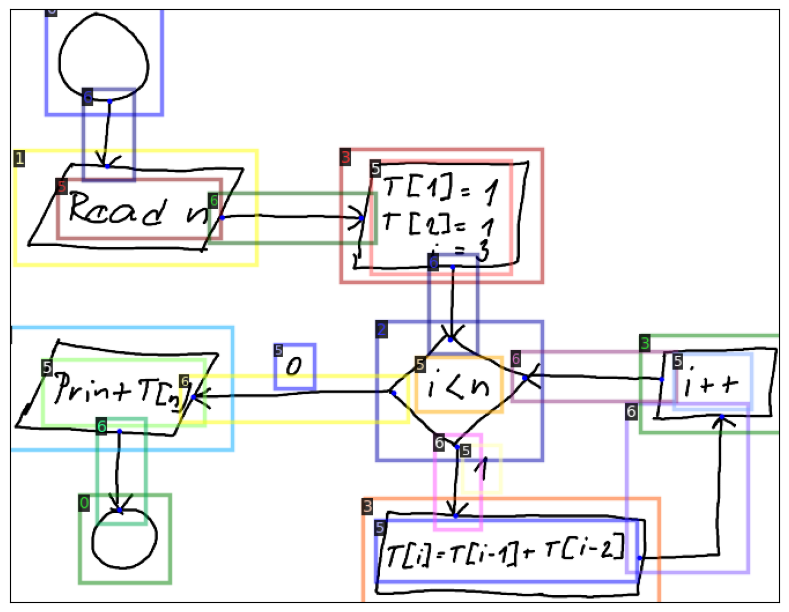

Predictions
Instances(num_instances=24, image_height=1027, image_width=1333, fields=[pred_boxes: Boxes(tensor([[7.0138e+02, 6.0187e+02, 8.4882e+02, 6.9760e+02],
        [7.3199e+02, 7.3613e+02, 8.1339e+02, 9.0178e+02],
        [6.3105e+02, 8.8610e+02, 1.0821e+03, 9.9089e+02],
        [1.1452e+03, 5.9681e+02, 1.2825e+03, 6.9248e+02],
        [6.2229e+02, 2.6224e+02, 8.6541e+02, 4.5969e+02],
        [1.0661e+03, 6.8237e+02, 1.2742e+03, 9.7502e+02],
        [7.6548e+01, 2.9323e+02, 3.6491e+02, 3.9809e+02],
        [5.2337e+01, 6.0619e+02, 3.3482e+02, 7.2111e+02],
        [1.2402e+02, 1.3875e+02, 2.1293e+02, 2.9378e+02],
        [1.4741e+02, 7.0766e+02, 2.3351e+02, 8.9075e+02],
        [7.2180e+02, 4.2381e+02, 8.0810e+02, 5.9616e+02],
        [7.8058e+02, 7.5483e+02, 8.4653e+02, 8.3718e+02],
        [8.6334e+02, 5.9240e+02, 1.1511e+03, 6.7925e+02],
        [3.4035e+02, 3.1881e+02, 6.3407e+02, 4.0489e+02],
        [5.4633e+00, 2.4571e+02, 4.2793e+02, 4.4483e+02],
        [1.2923e-01, 5.5145

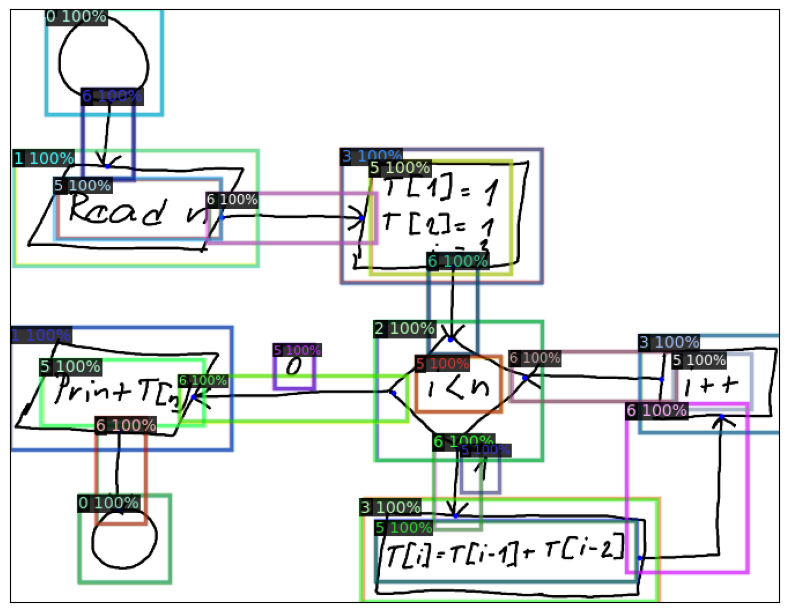

arrow_keypoints
--------------------------
bbox tensor(731.9912) tensor(736.1343) tensor(813.3851) tensor(901.7844)
w h center_x center_y tensor(81.3939) tensor(165.6501) tensor(772.6881) tensor(818.9594)
arrow_ab 736 739 736 762
arrow_rela tensor(-0.4506) tensor(-0.4780) tensor(-0.4394) tensor(-0.3387)
True
True
--------------------------
bbox tensor(1066.1187) tensor(682.3694) tensor(1274.1802) tensor(975.0224)
w h center_x center_y tensor(208.0615) tensor(292.6530) tensor(1170.1494) tensor(828.6959)
arrow_ab 1064 775 1095 701
arrow_rela tensor(-0.5073) tensor(-0.1832) tensor(-0.3570) tensor(-0.4344)
False
True
--------------------------
bbox tensor(124.0207) tensor(138.7537) tensor(212.9268) tensor(293.7784)
w h center_x center_y tensor(88.9061) tensor(155.0247) tensor(168.4738) tensor(216.2660)
arrow_ab 145 167 146 230
arrow_rela tensor(-0.2565) tensor(-0.3116) tensor(-0.2460) tensor(0.0934)
True
True
--------------------------
bbox tensor(147.4094) tensor(707.6564) tensor(233.5088

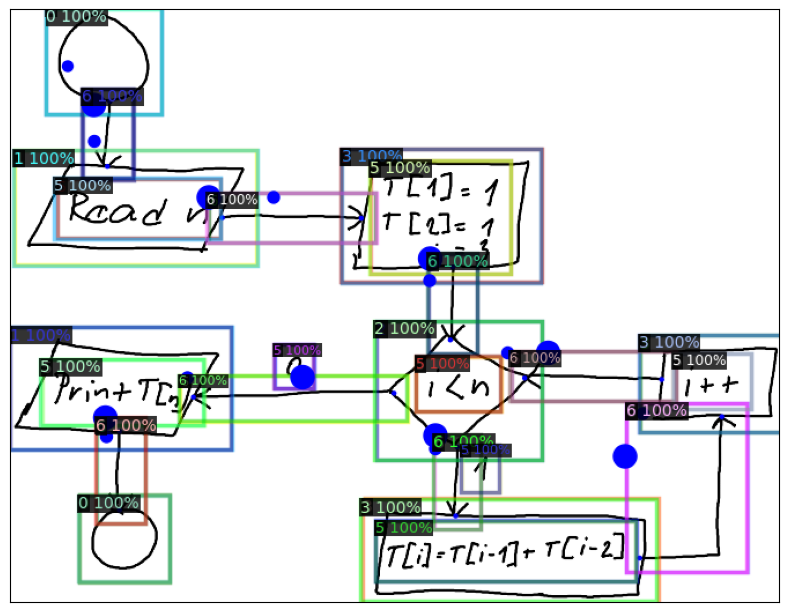

In [6]:
from pprint import pprint
# remove the colors of unsegmented pixels. This option is only available for segmentation models
visualizer = Visualizer(im, scale=0.5)

print("Ground truth")
gt_out = visualizer.draw_dataset_dict(example_gt)
show_img(gt_out.get_image())
# pprint(example_gt)

print("Predictions")
pred_out = visualizer.draw_instance_predictions(example_prediction["instances"].to("cpu"))
print(example_prediction["instances"].to("cpu"))
show_img(pred_out.get_image())

print("arrow_keypoints")
predictions = example_prediction["instances"].to("cpu")

for bbox, pred_arrow,cls in zip(predictions.pred_boxes, predictions.pred_arrow_keypoints,predictions.pred_classes):
    l_x, l_y, r_x, r_y = bbox
    s_x_r, s_y_r, e_x_r, e_y_r = pred_arrow
    if cls!=6:
        continue
    w = r_x - l_x
    h = r_y - l_y
    center_x = l_x + w / 2
    center_y = l_y + h / 2
    s_x = s_x_r * w + center_x 
    s_y = s_y_r * h + center_y 
    e_x = e_x_r * w + center_x 
    e_y = e_y_r * h + center_y 
    # 如果s_x小于0或者大于图像的宽度，那么就设置为0或者图像宽度
    def fix_coord(coord, max_coord):
        if coord < 0:
            return 0
        if coord > max_coord:
            return max_coord
        return int(coord)

    s_x = fix_coord(s_x, im.shape[1])
    s_y = fix_coord(s_y, im.shape[0])
    e_x = fix_coord(e_x, im.shape[1])
    e_y = fix_coord(e_y, im.shape[0])

    def isInbbox(x, y, bbox):
        l_x, l_y, r_x, r_y = bbox
        if x > l_x and x < r_x and y > l_y and y < r_y:
            return True
        return False
    print("--------------------------")
    print("bbox",l_x, l_y, r_x, r_y)
    print("w h center_x center_y",w,h,center_x,center_y)
    print("arrow_ab",s_x, s_y, e_x, e_y)
    print("arrow_rela",s_x_r, s_y_r, e_x_r, e_y_r)

    print(isInbbox(s_x, s_y, bbox))
    print(isInbbox(e_x, e_y, bbox))

    circle_out = visualizer.draw_circle(circle_coord = [s_x,s_y],color = '#FF0000',radius = 20)
    circle_out = visualizer.draw_circle(circle_coord = [e_x,e_y],color = '#FF0000',radius = 10)
    
    # arrow_pixel_positions.append([s_x, s_y, e_x, e_y])


circle_out = visualizer.draw_circle(circle_coord = [100,100],color = '#FF0000',radius = 9)
show_img(circle_out.get_image())


In [7]:
predictions = example_prediction["instances"].to("cpu")
print("predictions bbox:",predictions.pred_boxes)
print("predictions classes:",predictions.pred_classes)
print("predictions scores:",predictions.scores)
print("predictions pred_arrow:",predictions.pred_arrow_keypoints)

predictions bbox: Boxes(tensor([[7.0138e+02, 6.0187e+02, 8.4882e+02, 6.9760e+02],
        [7.3199e+02, 7.3613e+02, 8.1339e+02, 9.0178e+02],
        [6.3105e+02, 8.8610e+02, 1.0821e+03, 9.9089e+02],
        [1.1452e+03, 5.9681e+02, 1.2825e+03, 6.9248e+02],
        [6.2229e+02, 2.6224e+02, 8.6541e+02, 4.5969e+02],
        [1.0661e+03, 6.8237e+02, 1.2742e+03, 9.7502e+02],
        [7.6548e+01, 2.9323e+02, 3.6491e+02, 3.9809e+02],
        [5.2337e+01, 6.0619e+02, 3.3482e+02, 7.2111e+02],
        [1.2402e+02, 1.3875e+02, 2.1293e+02, 2.9378e+02],
        [1.4741e+02, 7.0766e+02, 2.3351e+02, 8.9075e+02],
        [7.2180e+02, 4.2381e+02, 8.0810e+02, 5.9616e+02],
        [7.8058e+02, 7.5483e+02, 8.4653e+02, 8.3718e+02],
        [8.6334e+02, 5.9240e+02, 1.1511e+03, 6.7925e+02],
        [3.4035e+02, 3.1881e+02, 6.3407e+02, 4.0489e+02],
        [5.4633e+00, 2.4571e+02, 4.2793e+02, 4.4483e+02],
        [1.2923e-01, 5.5145e+02, 3.8271e+02, 7.6239e+02],
        [6.0566e+02, 8.4967e+02, 1.1189e+03, 1.0

In [8]:
print("predictions pred_arrow len:",len(predictions.pred_arrow_keypoints))
print("predictions bbox len:",len(predictions.pred_boxes))

predictions pred_arrow len: 24
predictions bbox len: 24


In [9]:
arrow_pixel_positions = []
for bbox, pred_arrow in zip(predictions.pred_boxes, predictions.pred_arrow_keypoints):
    l_x, l_y, r_x, r_y = bbox
    s_x_r, s_y_r, e_x_r, e_y_r = pred_arrow

    s_x = s_x_r * (r_x - l_x) + (l_x + r_x) / 2
    s_y = s_y_r * (r_y - l_y) + (l_y + r_y) / 2
    e_x = e_x_r * (r_x - l_x) + (l_x + r_x) / 2
    e_y = e_y_r * (r_y - l_y) + (l_y + r_y) / 2

    arrow_pixel_positions.append([s_x, s_y, e_x, e_y])

arrow_pixel_positions


[[tensor(732.7245), tensor(618.7950), tensor(728.0347), tensor(615.3027)],
 [tensor(736.0113), tensor(739.7788), tensor(736.9224), tensor(762.8553)],
 [tensor(798.0818), tensor(914.8628), tensor(701.7426), tensor(915.9420)],
 [tensor(1186.3999), tensor(621.7615), tensor(1168.2610), tensor(623.6833)],
 [tensor(700.0272), tensor(335.1761), tensor(660.9122), tensor(328.9836)],
 [tensor(1064.5912), tensor(775.0802), tensor(1095.8689), tensor(701.5806)],
 [tensor(129.5046), tensor(313.7459), tensor(117.1296), tensor(310.5199)],
 [tensor(99.9828), tensor(628.3571), tensor(88.8179), tensor(624.9914)],
 [tensor(145.6689), tensor(167.9648), tensor(146.6040), tensor(230.7488)],
 [tensor(165.2056), tensor(708.2523), tensor(167.0986), tensor(741.1049)],
 [tensor(727.0949), tensor(433.4803), tensor(726.5564), tensor(471.2498)],
 [tensor(791.7923), tensor(768.9952), tensor(788.9149), tensor(767.9480)],
 [tensor(931.8732), tensor(596.4460), tensor(861.4078), tensor(596.4656)],
 [tensor(344.4207), ten

In [10]:
print(pred_out.get_image().shape)

(513, 666, 3)
